# Spatio-Temporal Feature extraction task

Notebook showing a workflow example implementing the spatio-temporal features proposed by Waldner et al. "automated annual cropland mapping using knowledge-based temporal features", 2015 ISPRS Journal of Photogrammetry and Remote Sensing

In [1]:
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

In [2]:
from sentinelhub import BBox, CRS

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
from eolearn.core import LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.features import AddSpatioTemporalFeaturesTask, AddMaxMinTemporalIndicesTask, AddMaxMinNDVISlopeIndicesTask

Define ROI BBOX and time interval

In [5]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-04-01', '2017-10-31')

### Compute cloud maps from new WMS request

In this workflow example, the cloud maps are computed from a new WMS request, as the input eopatch does not have the required data 

In [6]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
               np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [7]:
LAYER_NAME = 'BANDS-S2-L1C'
FEATURE_NAME = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=LAYER_NAME, 
                           resx='20m', resy='20m', 
                           maxcc=1, time_difference=datetime.timedelta(hours=2))

add_ndvi = S2L1CWCSInput(layer='NDVI')

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m', 
                           cm_size_x='60m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP')

add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=True)

add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature=LAYER_NAME, 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=True)

add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()

add_stf = AddSpatioTemporalFeaturesTask()

save = SaveToDisk('stf', overwrite_permission=1, compress_level=0)

Finished loading model, total used 170 iterations


Run workflow

In [8]:
workflow = LinearWorkflow(input_task, add_ndvi, add_clm, add_valmask, add_maxmin_ndvi, add_maxmin_red,
                          add_maxmin_ndvi_sl, add_stf)

result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

Plot results

In [9]:
eopatch, = [result[key] for key in result]
eopatch

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 278, 506, 13), dtype=float32)
    CLP: numpy.ndarray(shape=(66, 278, 506, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(66, 278, 506, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(66, 278, 506, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(66, 278, 506, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(66, 278, 506, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(278, 506, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(278, 506, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(278, 506, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(278, 506, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(278, 506, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(278, 506, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(278, 506, 20), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_t

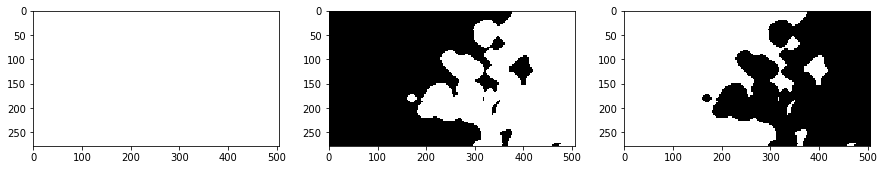

In [10]:
tidx = 5
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(eopatch.mask['IS_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.subplot(132)
plt.imshow(eopatch.mask['CLM'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.subplot(133)
plt.imshow(eopatch.mask['VALID_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')

In [11]:
acq_days = [ts.toordinal()-result[add_stf].timestamp[0].toordinal() for ts in result[add_stf].timestamp]

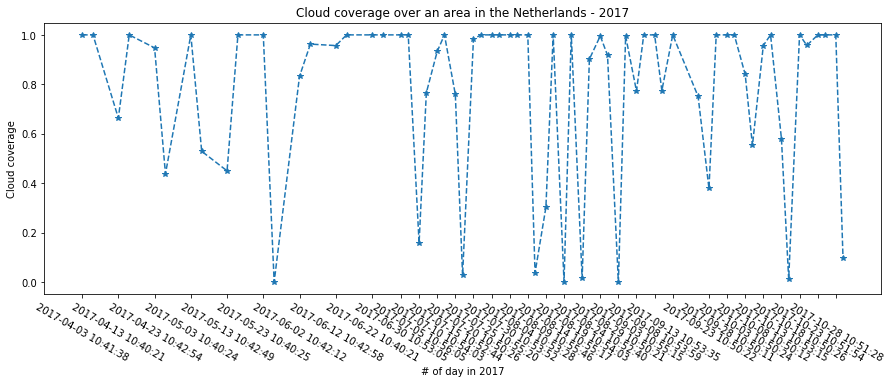

In [12]:
t, h, w, _ = result[add_stf].mask['CLM'].shape
cc = [np.sum(x)/(h*w) for x in result[add_stf].mask['CLM']]
plt.figure(figsize=(15,5))
plt.plot(acq_days, cc, '*--')
plt.ylabel('Cloud coverage')
plt.xlabel('# of day in 2017')
plt.title('Cloud coverage over an area in the Netherlands - 2017')
plt.xticks(acq_days[::2], eopatch.timestamp[::2], rotation=-30);

Display some of the spatio-temporal features

In [13]:
print(result[add_stf].data_timeless['STF'].shape)

(278, 506, 20)


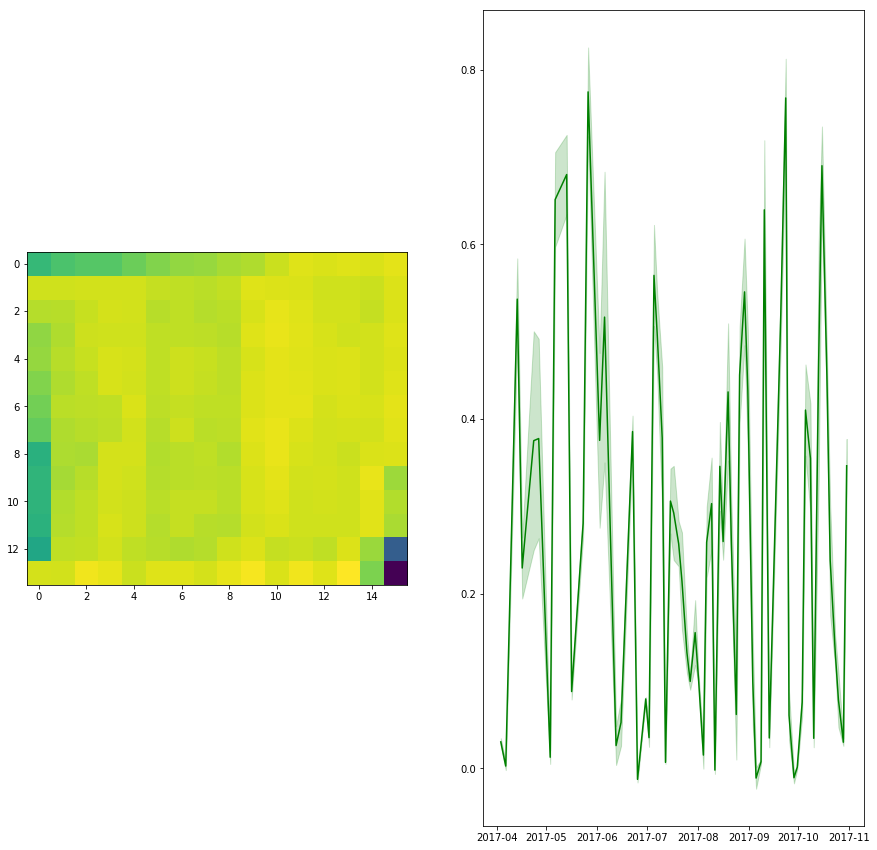

In [14]:
ndvi_patch = eopatch.data['NDVI'][:,227:241,314:330]
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(ndvi_patch[11].squeeze())
plt.subplot(122)
plt.plot(eopatch.timestamp, np.mean(ndvi_patch.squeeze(), axis=(1,2)),color='g')
plt.fill_between(eopatch.timestamp, 
                 np.mean(ndvi_patch.squeeze(), axis=(1,2))+np.std(ndvi_patch.squeeze(), axis=(1,2)),
                 np.mean(ndvi_patch.squeeze(), axis=(1,2))-np.std(ndvi_patch.squeeze(), axis=(1,2)),alpha=0.2,color='g');

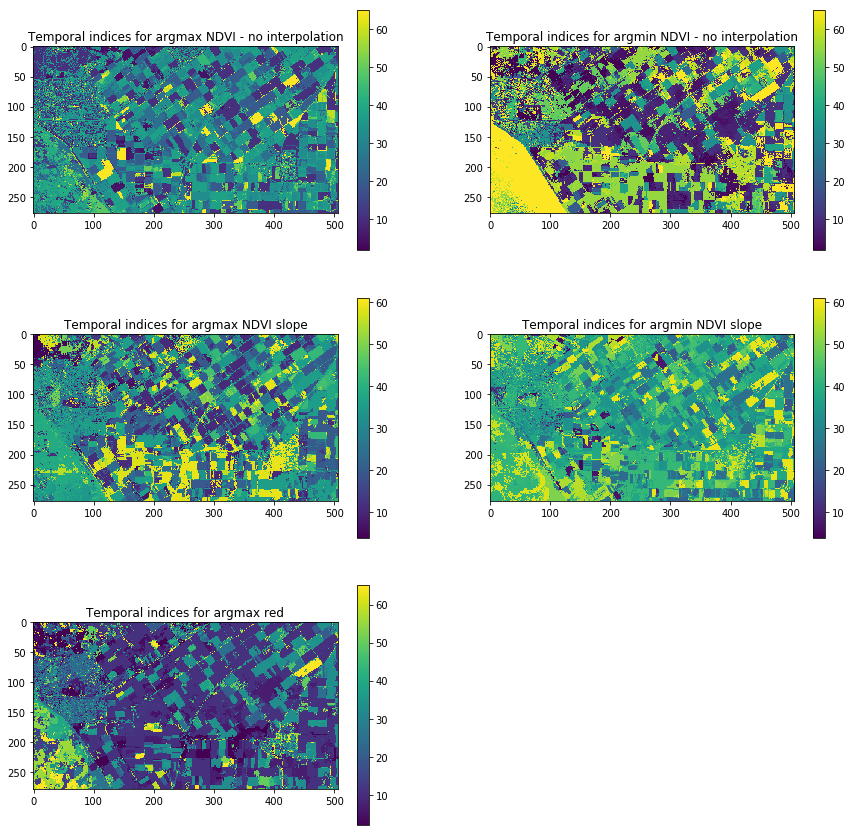

In [15]:
plt.figure(figsize=(15,15))
plt.tight_layout()
plt.subplot(321)
plt.imshow(eopatch.data_timeless['ARGMAX_NDVI'].squeeze())
plt.title("Temporal indices for argmax NDVI - no interpolation")
plt.colorbar()
plt.subplot(322)
plt.imshow(eopatch.data_timeless['ARGMIN_NDVI'].squeeze())
plt.title("Temporal indices for argmin NDVI - no interpolation")
plt.colorbar()
plt.subplot(323)
plt.imshow(eopatch.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
plt.title("Temporal indices for argmax NDVI slope")
plt.colorbar()
plt.subplot(324)
plt.imshow(eopatch.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
plt.title("Temporal indices for argmin NDVI slope")
plt.colorbar()
plt.subplot(325)
plt.imshow(eopatch.data_timeless['ARGMAX_B4'].squeeze())
plt.title("Temporal indices for argmax red")
plt.colorbar();

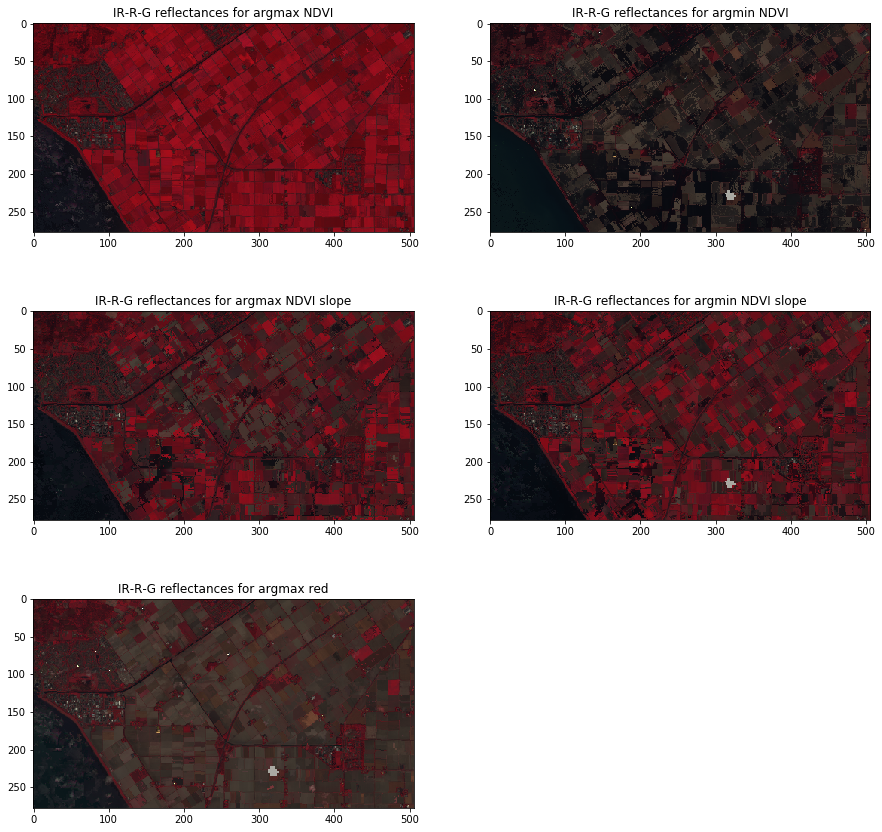

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.imshow(eopatch.data_timeless['STF'][:,:,[2,1,0]])
plt.title("IR-R-G reflectances for argmax NDVI")
plt.subplot(322)
plt.imshow(eopatch.data_timeless['STF'][:,:,[6,5,4]])
plt.title("IR-R-G reflectances for argmin NDVI")
plt.subplot(323)
plt.imshow(eopatch.data_timeless['STF'][:,:,[10,9,8]])
plt.title("IR-R-G reflectances for argmax NDVI slope")
plt.subplot(324)
plt.imshow(eopatch.data_timeless['STF'][:,:,[14,13,12]])
plt.title("IR-R-G reflectances for argmin NDVI slope")
plt.subplot(325)
plt.imshow(eopatch.data_timeless['STF'][:,:,[18,17,16]])
plt.title("IR-R-G reflectances for argmax red");

In [17]:
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMAX_NDVI')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMIN_NDVI')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMAX_NDVI_SLOPE')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMIN_NDVI_SLOPE')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMAX_B4')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'ARGMIN_B4')
eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'STF')
eopatch.remove_feature(FeatureType.DATA, 'CLP')
eopatch.remove_feature(FeatureType.MASK, 'CLM')

In [18]:
save(eopatch, eopatch_folder='eopatch')

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 278, 506, 13), dtype=float32)
    NDVI: numpy.ndarray(shape=(66, 278, 506, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(66, 278, 506, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(66, 278, 506, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(0, 7200)
    time_interval: [datetime.datetime(2017, 4, 1, 0, 0), datetime.datetime(2017, 10, 31, 0, 0)]
  }
  bbox: BBox(((5.6, 52.63), (5.75, 52.68)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2017, 4, 3, 10, 41, 38), ..., datetime.datetime(2017, 10, 30, 10, 41, 50)], length=66
)

### Repeat using interpolation to NDVI and bands

In [19]:
from eolearn.features import SplineInterpolation

In [20]:
load = LoadFromDisk('stf')

interp_ndvi = SplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'),
                                  spline_degree=3, smoothing_factor=0.1)

interp_bands = SplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'),
                                   spline_degree=3, smoothing_factor=0.1)

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=False)

add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature=LAYER_NAME, 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=False)

add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()

add_stf = AddSpatioTemporalFeaturesTask()

In [ ]:
workflow_with_interp = LinearWorkflow(load, interp_ndvi, interp_bands, add_maxmin_ndvi,
                                      add_maxmin_red, add_maxmin_ndvi_sl, add_stf)

result_with_interp = workflow_with_interp.execute({load:{'eopatch_folder':'eopatch'}})

In [ ]:
eopatch_wi, = [result_with_interp[key] for key in result_with_interp]
eopatch_wi.features

In [ ]:
ndvi_patch = eopatch_wi.data['NDVI'][:,227:241,314:330]
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(ndvi_patch[11].squeeze())
plt.subplot(122)
plt.plot(eopatch_wi.timestamp, np.mean(ndvi_patch.squeeze(), axis=(1,2)),color='g')
plt.fill_between(eopatch_wi.timestamp, 
                 np.mean(ndvi_patch.squeeze(), axis=(1,2))+np.std(ndvi_patch.squeeze(), axis=(1,2)),
                 np.mean(ndvi_patch.squeeze(), axis=(1,2))-np.std(ndvi_patch.squeeze(), axis=(1,2)),alpha=0.2,color='g')

In [ ]:
plt.figure(figsize=(15,15))
plt.tight_layout()
plt.subplot(321)
plt.imshow(eopatch_wi.data_timeless['ARGMAX_NDVI'].squeeze())
plt.title("Temporal indices for argmax NDVI - no interpolation")
plt.colorbar()
plt.subplot(322)
plt.imshow(eopatch_wi.data_timeless['ARGMIN_NDVI'].squeeze())
plt.title("Temporal indices for argmin NDVI - no interpolation")
plt.colorbar()
plt.subplot(323)
plt.imshow(eopatch_wi.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
plt.title("Temporal indices for argmax NDVI slope")
plt.colorbar()
plt.subplot(324)
plt.imshow(eopatch_wi.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
plt.title("Temporal indices for argmin NDVI slope")
plt.colorbar()
plt.subplot(325)
plt.imshow(eopatch_wi.data_timeless['ARGMAX_B4'].squeeze())
plt.title("Temporal indices for argmax red")
plt.colorbar();

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.imshow(eopatch_wi.data_timeless['STF'][:,:,[2,1,0]])
plt.title("IR-R-G reflectances for argmax NDVI")
plt.subplot(322)
plt.imshow(eopatch_wi.data_timeless['STF'][:,:,[6,5,4]])
plt.title("IR-R-G reflectances for argmin NDVI")
plt.subplot(323)
plt.imshow(eopatch_wi.data_timeless['STF'][:,:,[10,9,8]])
plt.title("IR-R-G reflectances for argmax NDVI slope")
plt.subplot(324)
plt.imshow(eopatch_wi.data_timeless['STF'][:,:,[14,13,12]])
plt.title("IR-R-G reflectances for argmin NDVI slope")
plt.subplot(325)
plt.imshow(eopatch_wi.data_timeless['STF'][:,:,[18,17,16]])
plt.title("IR-R-G reflectances for argmax red");

In [ ]:
del eopatch_wi